In [2]:
import re
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [80]:
df = pd.read_csv("Egypt_Tourism_Sentiment_Analysis.csv")

In [6]:
df.head()

,review,processed_review,sentiment_ensemble
0,Well worth going to visit. If you are getting ...,well worth going visit getting tour fantastic ...,positive
1,The splendor of the pyramidsThe Seven Wonders ...,splendor pyramidsthe seven wonder world seen p...,positive
2,The pyramids are among the most beautiful arch...,pyramid among beautiful archaeological site wo...,positive
3,"yes it crowded, yes there is some tourist trap...",yes crowded yes tourist trap yes queue frustra...,positive
4,"History & Mystery of The Pyramids, What a Day,...",history mystery pyramid day hit visit land leg...,positive


In [8]:
df.columns

Index(['review', 'processed_review', 'sentiment_ensemble'], dtype='object')

In [82]:
df['sentiment_ensemble'] = df['sentiment_ensemble'].replace('non_positive', 'negative')
df['sentiment_ensemble'] = df['sentiment_ensemble'].replace('neutral', 'negative')

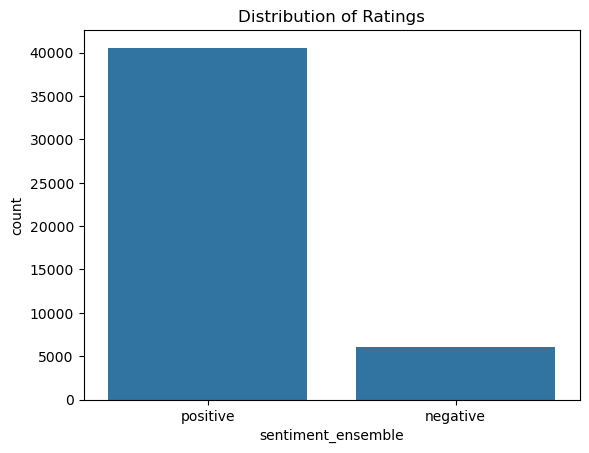

In [60]:
if 'sentiment_ensemble' in df.columns:
    sns.countplot(data=df, x='sentiment_ensemble')
    plt.title('Distribution of Ratings')
    plt.show()

Handling class imbalance by Upsamling data

In [84]:
from sklearn.utils import resample
import pandas as pd

df_majority = df[df.sentiment_ensemble == 'positive']
df_minority = df[df.sentiment_ensemble != 'positive'] 

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X = df_upsampled['processed_review']
y = df_upsampled['sentiment_ensemble']


In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)


In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [90]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


Logistic Regression

Accuracy: 0.8965750893187138
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8117
           1       0.92      0.87      0.89      8117

    accuracy                           0.90     16234
   macro avg       0.90      0.90      0.90     16234
weighted avg       0.90      0.90      0.90     16234



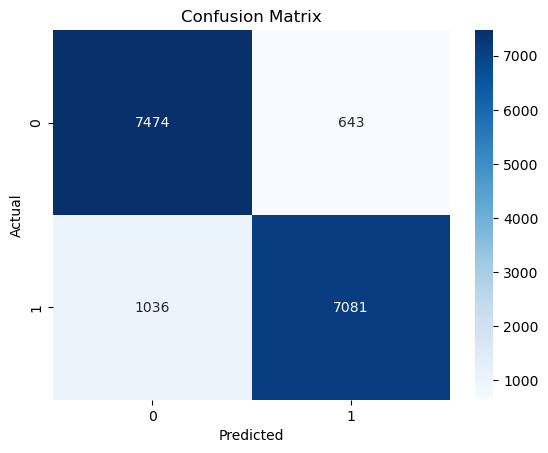

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model
LR_model = LogisticRegression(max_iter=1000, class_weight='balanced')
LR_model.fit(X_train_tfidf, y_train_encoded)

# Predict
y_pred = LR_model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Check if the model isn't overfitting

In [100]:
from sklearn.metrics import accuracy_score

y_train_pred = LR_model.predict(X_train_tfidf)
train_acc = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_acc)

test_acc = accuracy_score(y_test_encoded, y_pred)
print("Test Accuracy:", test_acc)



Train Accuracy: 0.9137123848831121
Test Accuracy: 0.8965750893187138


In [103]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(LR_model, X_train_tfidf, y_train_encoded, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-validation scores: [0.8985139  0.8975899  0.8983599  0.8956649  0.89604189]
Mean CV Accuracy: 0.8972340962792218


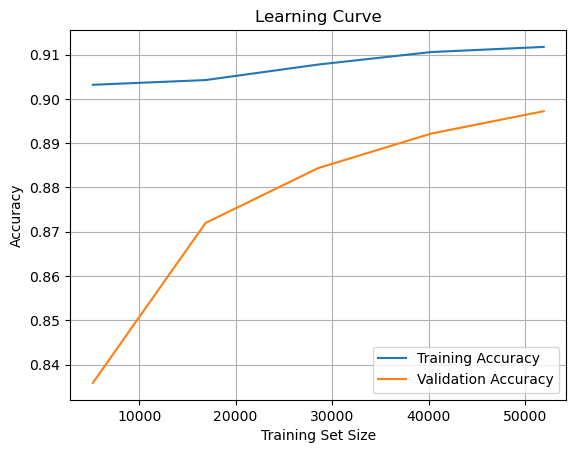

In [107]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    LR_model, X_train_tfidf, y_train_encoded, cv=5, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


[LightGBM] [Info] Number of positive: 32467, number of negative: 32467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.518499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306838
[LightGBM] [Info] Number of data points in the train set: 64934, number of used features: 4947
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.8848096587409141

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89      8117
           1       0.91      0.86      0.88      8117

    accuracy                           0.88     16234
   macro avg       0.89      0.88      0.88     16234
weighted avg       0.89      0.88      0.88     16234



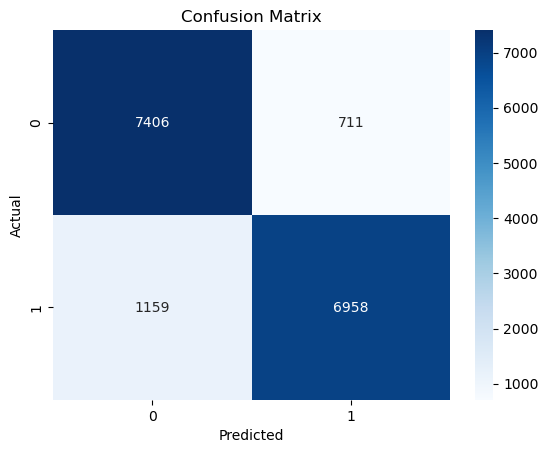

In [96]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_tfidf, y_train_encoded)

y_pred_lgb = lgb_model.predict(X_test_tfidf)

print("LightGBM Accuracy:", accuracy_score(y_test_encoded, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_lgb))


# Confusion matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

XGBoost Accuracy: 0.9066773438462487

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      8117
           1       0.94      0.87      0.90      8117

    accuracy                           0.91     16234
   macro avg       0.91      0.91      0.91     16234
weighted avg       0.91      0.91      0.91     16234



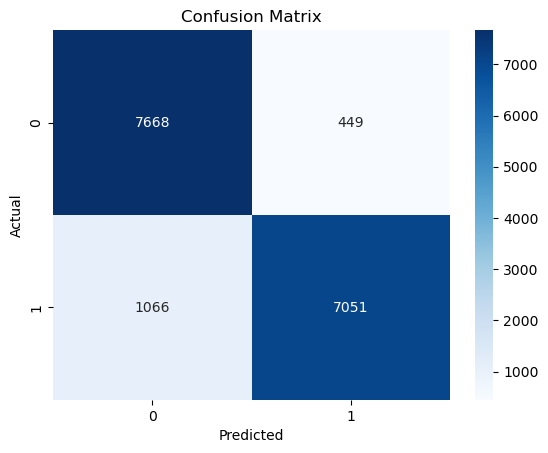

In [98]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train_encoded)

y_pred_xgb = xgb_model.predict(X_test_tfidf)

print("XGBoost Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_xgb))

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM

SVM Accuracy: 0.9138228409510903

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      8117
           1       0.94      0.88      0.91      8117

    accuracy                           0.91     16234
   macro avg       0.92      0.91      0.91     16234
weighted avg       0.92      0.91      0.91     16234



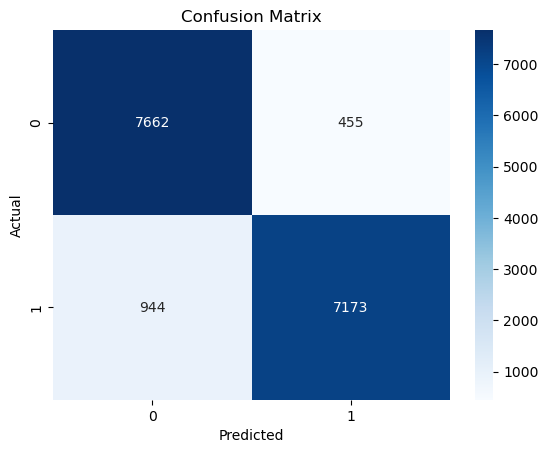

In [117]:
svm_model = LinearSVC(max_iter=2000, random_state=42)
svm_model.fit(X_train_tfidf, y_train_encoded)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test_encoded, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_svm))

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SGD Accuracy: 0.916902796599729

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      8117
           1       0.94      0.89      0.91      8117

    accuracy                           0.92     16234
   macro avg       0.92      0.92      0.92     16234
weighted avg       0.92      0.92      0.92     16234



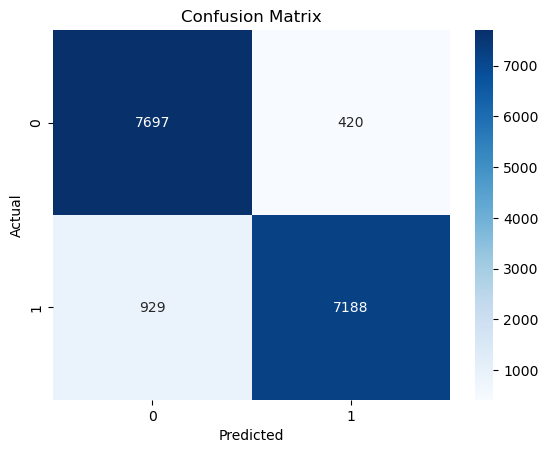

In [119]:
from sklearn.linear_model import SGDClassifier

sgd_model = make_pipeline(StandardScaler(with_mean=False), SGDClassifier(loss='hinge',class_weight='balanced', max_iter=1000, random_state=42))
sgd_model.fit(X_train_tfidf, y_train_encoded)

y_pred_sgd = sgd_model.predict(X_test_tfidf)
print("SGD Accuracy:", accuracy_score(y_test_encoded, y_pred_sgd))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_sgd))

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_sgd), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


SGD Accuracy: 0.9892817543427375

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      8117
           1       1.00      0.98      0.99      8117

    accuracy                           0.99     16234
   macro avg       0.99      0.99      0.99     16234
weighted avg       0.99      0.99      0.99     16234



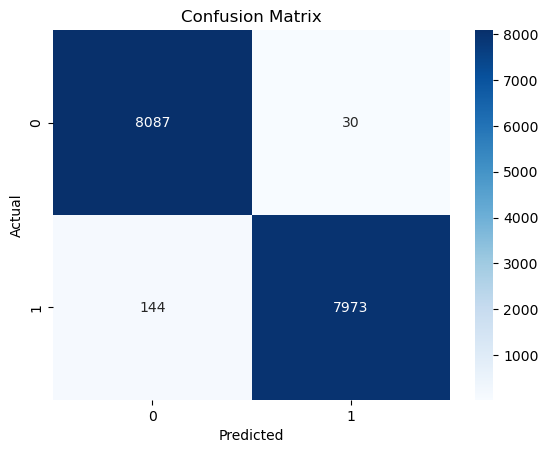

In [158]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_tfidf, y_train_encoded)
y_pred_RF = model.predict(X_test_tfidf)
print("SGD Accuracy:", accuracy_score(y_test_encoded, y_pred_RF))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_RF))

sns.heatmap(confusion_matrix(y_test_encoded,y_pred_RF), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


LSTM

In [140]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


In [142]:
label_encoder = LabelEncoder()
df_upsampled['sentiment_encoded'] = label_encoder.fit_transform(df_upsampled['sentiment_ensemble'])

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_upsampled['processed_review'])
sequences = tokenizer.texts_to_sequences(df_upsampled['processed_review'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df_upsampled['sentiment_encoded'], test_size=0.2, random_state=42
)

In [146]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])


C:\Users\start\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [148]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, validation_split=0.1, batch_size=64)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Epoch 1/3
914/914 ━━━━━━━━━━━━━━━━━━━━ 634s 667ms/step - accuracy: 0.7962 - loss: 0.4105 - val_accuracy: 0.9279 - val_loss: 0.1964
Epoch 2/3
914/914 ━━━━━━━━━━━━━━━━━━━━ 544s 595ms/step - accuracy: 0.9506 - loss: 0.1412 - val_accuracy: 0.9469 - val_loss: 0.1566
Epoch 3/3
914/914 ━━━━━━━━━━━━━━━━━━━━ 586s 620ms/step - accuracy: 0.9725 - loss: 0.0845 - val_accuracy: 0.9617 - val_loss: 0.1201
508/508 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step
              precision    recall  f1-score   support

    negative       0.95      0.98      0.96      8091
    positive       0.97      0.95      0.96      8143

    accuracy                           0.96     16234
   macro avg       0.96      0.96      0.96     16234
weighted avg       0.96      0.96      0.96     16234



In [150]:
# Example reviews
test_reviews = [
    "I absolutely loved my trip to Egypt, the pyramids were breathtaking!",
    "It was dirty, crowded, and overpriced — very disappointing.",
    "The tour guide was okay, but the rest was just bad and I didn't like the weather."
]

# Tokenize and pad them
test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_sequences, maxlen=200, padding='post', truncating='post')

# Predict
pred_probs = model.predict(test_padded)
pred_classes = np.argmax(pred_probs, axis=1)

# Decode predictions
pred_labels = label_encoder.inverse_transform(pred_classes)

# Show results
for review, label in zip(test_reviews, pred_labels):
    print(f"Review: {review}\nPredicted Sentiment: {label}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Review: I absolutely loved my trip to Egypt, the pyramids were breathtaking!
Predicted Sentiment: positive

Review: It was dirty, crowded, and overpriced — very disappointing.
Predicted Sentiment: negative

Review: The tour guide was okay, but the rest was just bad and I didn't like the weather.
Predicted Sentiment: negative



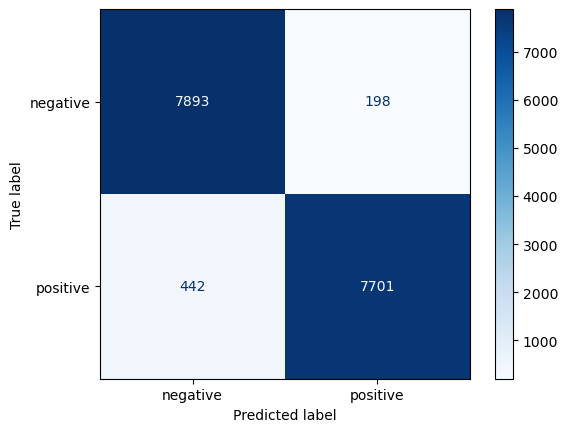

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.show()


GRU

In [154]:
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, validation_split=0.1, batch_size=64)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

C:\Users\start\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
914/914 ━━━━━━━━━━━━━━━━━━━━ 698s 709ms/step - accuracy: 0.7915 - loss: 0.4281 - val_accuracy: 0.9299 - val_loss: 0.1921
Epoch 2/3
914/914 ━━━━━━━━━━━━━━━━━━━━ 635s 695ms/step - accuracy: 0.9508 - loss: 0.1446 - val_accuracy: 0.9481 - val_loss: 0.1577
Epoch 3/3
914/914 ━━━━━━━━━━━━━━━━━━━━ 644s 653ms/step - accuracy: 0.9708 - loss: 0.0876 - val_accuracy: 0.9593 - val_loss: 0.1446
508/508 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step
              precision    recall  f1-score   support

    negative       0.94      0.98      0.96      8091
    positive       0.98      0.94      0.96      8143

    accuracy                           0.96     16234
   macro avg       0.96      0.96      0.96     16234
weighted avg       0.96      0.96      0.96     16234



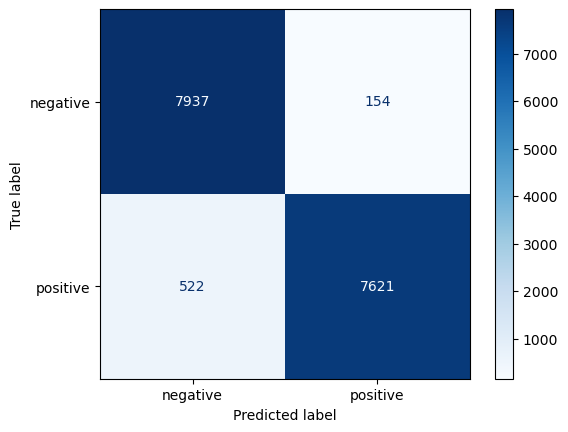

In [156]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.show()
